<a href="https://colab.research.google.com/github/jtunde/Python/blob/main/CN2%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
df = pd.read_csv('drive/MyDrive/data.csv',index_col='TIME',parse_dates=True)
print(df.head())

               RON
TIME              
2021-01-01  4.9493
2021-01-02  4.9493
2021-01-03  4.9493
2021-01-04  4.8713
2021-01-05  4.8721


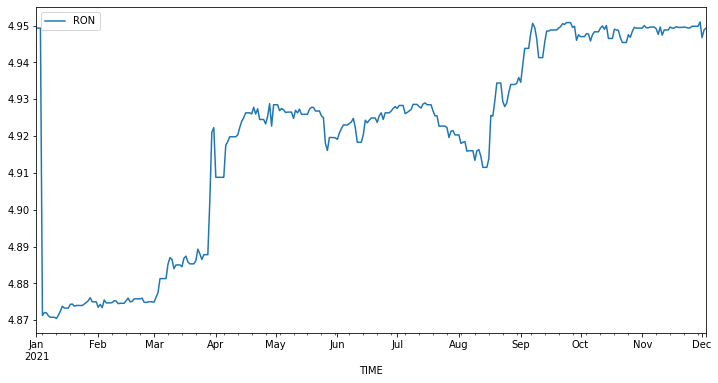

In [14]:


df.plot(figsize=(12,6))



In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


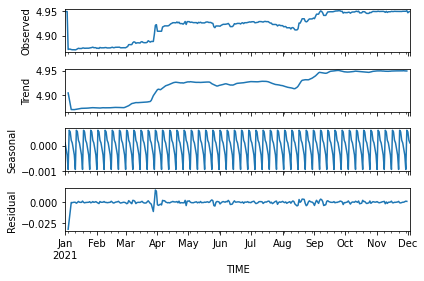

In [17]:
results = seasonal_decompose(df['RON'])
results.plot();

In [18]:
len(df)

337

In [22]:
train = df.iloc[:274]
test = df.iloc[274:]

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [20]:
df.head(),df.tail()

(               RON
 TIME              
 2021-01-01  4.9493
 2021-01-02  4.9493
 2021-01-03  4.9493
 2021-01-04  4.8713
 2021-01-05  4.8721,                RON
 TIME              
 2021-11-29  4.9498
 2021-11-30  4.9510
 2021-12-01  4.9467
 2021-12-02  4.9488
 2021-12-03  4.9493)

In [24]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [25]:
scaled_train[:10]

array([[0.98132005],
       [0.98132005],
       [0.98132005],
       [0.00996264],
       [0.01992528],
       [0.01867995],
       [0.00871731],
       [0.00373599],
       [0.00373599],
       [0.00373599]])

In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [28]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.98132005 0.98132005 0.98132005]
Predict this y: 
 [[0.00996264]]


In [29]:
X.shape

(1, 3, 1)

In [30]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [32]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [34]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
262/262 [==============================] - 4s 7ms/step - loss: 0.0225
Epoch 2/50
262/262 [==============================] - 2s 7ms/step - loss: 0.0039
Epoch 3/50
262/262 [==============================] - 2s 7ms/step - loss: 0.0036
Epoch 4/50
262/262 [==============================] - 2s 7ms/step - loss: 0.0031
Epoch 5/50
262/262 [==============================] - 2s 7ms/step - loss: 0.0030
Epoch 6/50
262/262 [==============================] - 2s 8ms/step - loss: 0.0032
Epoch 7/50
262/262 [==============================] - 2s 7ms/step - loss: 0.0029
Epoch 8/50
262/262 [==============================] - 2s 7ms/step - loss: 0.0029
Epoch 9/50
262/262 [==============================] - 2s 7ms/step - loss: 0.0026
Epoch 10/50
262/262 [==============================] - 2s 8ms/step - loss: 0.0022
Epoch 11/50
262/262 [==============================] - 2s 7ms/step - loss: 0.0023
Epoch 12/50
262/262 [==============================] - 2s 7ms/step - loss: 0.0021
Epoch 13/50
262/262 [====

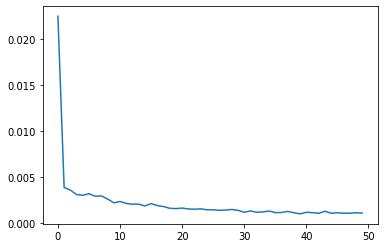

In [35]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [36]:
last_train_batch = scaled_train[-12:]

In [37]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [38]:
model.predict(last_train_batch)

array([[0.959579]], dtype=float32)

In [39]:
scaled_test[0]

array([0.95267746])

In [40]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



In [41]:
test_predictions

[array([0.959579], dtype=float32),
 array([0.97047955], dtype=float32),
 array([0.9800619], dtype=float32),
 array([0.9885391], dtype=float32),
 array([0.9963231], dtype=float32),
 array([1.0035003], dtype=float32),
 array([1.0103089], dtype=float32),
 array([1.0169246], dtype=float32),
 array([1.0234405], dtype=float32),
 array([1.0300093], dtype=float32),
 array([1.0366122], dtype=float32),
 array([1.0432489], dtype=float32),
 array([1.0499078], dtype=float32),
 array([1.056571], dtype=float32),
 array([1.0632294], dtype=float32),
 array([1.0698825], dtype=float32),
 array([1.0765337], dtype=float32),
 array([1.083189], dtype=float32),
 array([1.0898528], dtype=float32),
 array([1.0965314], dtype=float32),
 array([1.1032307], dtype=float32),
 array([1.1099561], dtype=float32),
 array([1.116713], dtype=float32),
 array([1.1235061], dtype=float32),
 array([1.1303402], dtype=float32),
 array([1.1372201], dtype=float32),
 array([1.1441512], dtype=float32),
 array([1.1511378], dtype=float

In [43]:
test.head()

,RON
TIME,
2021-10-02,4.9470
2021-10-03,4.9470
2021-10-04,4.9478
2021-10-05,4.9477
2021-10-06,4.9458


In [44]:
true_predictions = scaler.inverse_transform(test_predictions)

In [45]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


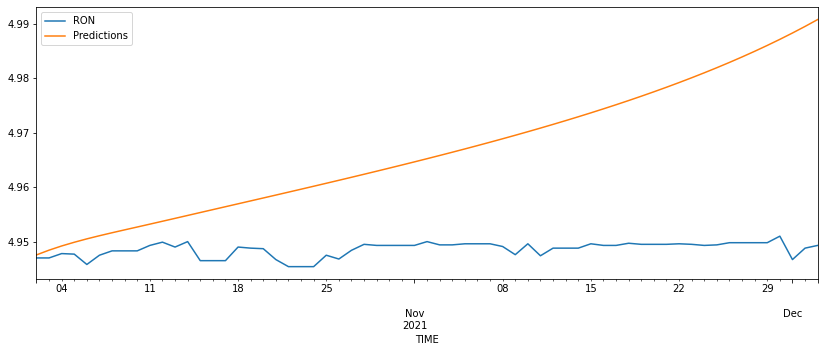

In [46]:
test.plot(figsize=(14,5))

In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['RON'],test['Predictions']))
print(rmse)

0.021188287933994576
